In [8]:
import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [9]:
data_train = pd.read_csv('features.csv')

In [10]:
data_train.shape

(97230, 109)

In [11]:
data_train.tail()

,match_id,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
97225,114402,1450265551,1,47,4,1706,1198,17,0,1,...,4,3,0,-24.0,2032,0,1792,1975,48,63
97226,114403,1450277704,0,43,4,1793,1416,17,0,1,...,3,2,0,-17.0,1734,1,2038,6,63,3
97227,114404,1450291848,1,98,4,1399,540,1,0,0,...,1,3,1,-15.0,2906,0,1796,1846,51,63
97228,114405,1450292986,1,100,3,1135,766,6,0,2,...,3,3,1,-42.0,951,0,2039,2047,63,63
97229,114406,1450313370,7,50,3,1053,799,7,0,0,...,3,2,0,-39.0,2086,1,1982,0,63,0


In [12]:
data_train.describe()

,match_id,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
count,97230.000000,9.723000e+04,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,...,97230.000000,97230.000000,97230.000000,95404.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000
mean,57185.416744,1.444232e+09,2.630999,51.517104,3.442672,1233.405801,1147.899702,11.231996,0.357009,0.362285,...,3.349553,2.448339,0.689119,-6.901922,2332.247886,0.518503,1309.227790,1286.310820,40.599095,41.337036
std,33007.123878,5.515393e+06,2.835761,32.564211,1.111741,566.588895,464.111662,9.041620,0.663889,0.626704,...,1.155609,0.813459,0.710122,40.701397,715.806850,0.499660,853.921365,851.009148,27.871645,27.064873
min,0.000000,1.430199e+09,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-84.000000,900.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28545.250000,1.440815e+09,1.000000,22.000000,3.000000,767.000000,746.000000,2.000000,0.000000,0.000000,...,3.000000,2.000000,0.000000,-31.000000,1818.000000,0.000000,36.000000,256.000000,3.000000,3.000000
50%,57160.500000,1.446338e+09,1.000000,50.000000,3.000000,1175.000000,1113.000000,11.000000,0.000000,0.000000,...,3.000000,2.000000,1.000000,-16.000000,2268.000000,1.000000,1824.000000,1798.000000,63.000000,60.000000
75%,85755.750000,1.448829e+09,7.000000,75.000000,4.000000,1704.000000,1479.000000,19.000000,1.000000,1.000000,...,4.000000,3.000000,1.000000,8.000000,2778.000000,1.000000,1974.000000,1974.000000,63.000000,63.000000
max,114406.000000,1.450313e+09,7.000000,112.000000,6.000000,3319.000000,4332.000000,47.000000,8.000000,5.000000,...,9.000000,9.000000,13.000000,300.000000,8452.000000,1.000000,2047.000000,2047.000000,63.000000,63.000000


In [13]:
# Удаляем признаки - итоги матча
data_train.drop(['duration', 
         'tower_status_radiant', 
         'tower_status_dire', 
         'barracks_status_radiant', 
         'barracks_status_dire'
        ], axis=1, inplace=True)

In [14]:
# Формируем массив с целевой переменной
y_train = data_train['radiant_win']
del data_train['radiant_win']

In [15]:
y_train.shape, data_train.shape

((97230,), (97230, 103))

### Подход 1: градиентный бустинг "в лоб"

Один из самых универсальных алгоритмов, изученных в нашем курсе, является градиентный бустинг. Он не очень требователен к данным, восстанавливает нелинейные зависимости, и хорошо работает на многих наборах данных, что и обуславливает его популярность. Вполне разумной мыслью будет попробовать именно его в первую очередь.

1.Считайте таблицу с признаками из файла features.csv с помощью кода, приведенного выше. Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).

2.Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

3.Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.

4.Какой столбец содержит целевую переменную? Запишите его название.

5.Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

###  Data preprocessing   

In [42]:
X_train_gb = data_train
X_train_gb.shape

(97230, 103)

In [43]:
X_train_gb.isnull().sum()

match_id                           0
start_time                         0
lobby_type                         0
r1_hero                            0
r1_level                           0
r1_xp                              0
r1_gold                            0
r1_lh                              0
r1_kills                           0
r1_deaths                          0
r1_items                           0
r2_hero                            0
r2_level                           0
r2_xp                              0
r2_gold                            0
r2_lh                              0
r2_kills                           0
r2_deaths                          0
r2_items                           0
r3_hero                            0
r3_level                           0
r3_xp                              0
r3_gold                            0
r3_lh                              0
r3_kills                           0
r3_deaths                          0
r3_items                           0
r

In [46]:
# Заменяем пропуски на средние значения по столбцу
X_train_gb = X_train_gb.fillna(X_train_gb.mean())

In [50]:
%%time
# Подбираем оптимальное число деревьев

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
N = [10, 30, 50, 100]
for n in N:
    print ('--- N_estimators = ', str(n))
    model = GradientBoostingClassifier(n_estimators=n, random_state=42)
    start_time = datetime.datetime.now()
    model_scores = cross_val_score(model, X_train_gb, y_train, cv=kf, scoring='roc_auc', n_jobs=-1)
    print ('Time elapsed:', datetime.datetime.now() - start_time)
    print (model_scores)
    scores.append(max(model_scores))

--- N_estimators =  10
Time elapsed: 0:00:28.202836
[0.6628393  0.6690325  0.65778594 0.66141503 0.66504144]
--- N_estimators =  30
Time elapsed: 0:01:21.018898
[0.68679836 0.69049064 0.68466605 0.68999469 0.69272758]
--- N_estimators =  50
Time elapsed: 0:02:03.592194
[0.69548905 0.69712892 0.69344154 0.69845041 0.70048886]
--- N_estimators =  100
Time elapsed: 0:04:24.031007
[0.70398016 0.70602234 0.70366821 0.70758957 0.70955201]
CPU times: user 4.84 s, sys: 826 ms, total: 5.67 s
Wall time: 8min 16s


In [51]:
scores

[0.6690324994558224, 0.6927275801527567, 0.700488856402555, 0.7095520064860807]

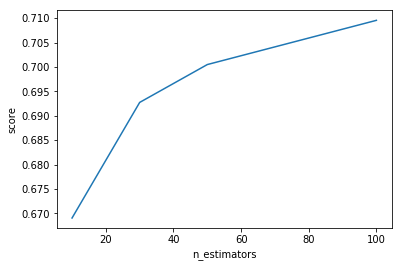

In [52]:
plt.plot(N, scores)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.show()

In [656]:
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

In [657]:
%%time
gb.fit(X_train_gb, y_train)

CPU times: user 1min 24s, sys: 693 ms, total: 1min 24s
Wall time: 1min 25s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

**Что указать в отчете**:

В отчете по данному этапу вы должны ответить на следующие вопросы:

1.Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?

2.Как называется столбец, содержащий целевую переменную?

3.Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Инструкцию по измерению времени можно найти ниже по тексту. Какое качество при этом получилось? Напомним, что в данном задании мы используем метрику качества AUC-ROC.

4.Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?

**Ответы**:

1.Пропуски:
first_blood_time              - 19553
first_blood_team              - 19553
first_blood_player1            - 19553
first_blood_player2            - 43987
radiant_bottle_time            - 15691
radiant_courier_time           -  692
radiant_flying_courier_time   - 27479
radiant_first_ward_time       -  1836
dire_bottle_time              - 16143
dire_courier_time             -  676
dire_flying_courier_time      - 26098
dire_first_ward_time          -  1826

Например,
first_blood_time (игровое время первой крови) - первой крови может не быть в первые 5 минут игры, 
first_blood_team (команда, совершившая первую кровь) - соответственно, этот признак так же будет пустым

2.radiant_win

3.Кросс-валидация для градиентного бустинга с 30 деревьями заняла 0:01:19, метрика качества AUC-ROC равна 0.69272.

4.Как видно из графика, качество модели продолжает расти при росте количества деревьев, но незначительно: на 100 деревьях метрика качества AUC-ROC равна 0.70616 - что ненамного превышает результат с 30 дереьвями. В принципе, можно остановиться на количестве дереьвев 30. Для увеличения качества можно также поиграться с такими параметрами GradientBoostingClassifier, как: learning_rate, max_depth,min_samples_leaf. В целом, для уменьшения времени обучения модели можно сократить глубину деревьев (по умолчанию, стоит 3) или уменьшить размер обучающей выборки.

### Подход 2: логистическая регрессия

Линейные методы работают гораздо быстрее композиций деревьев, поэтому кажется разумным воспользоваться именно ими для ускорения анализа данных. Одним из наиболее распространенных методов для классификации является логистическая регрессия.

Важно: не забывайте, что линейные алгоритмы чувствительны к масштабу признаков! Может пригодиться sklearn.preprocessing.StandartScaler.

1.Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

2.Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?

3.На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).

4.Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данной преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.

5.Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?

6.Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

In [16]:
X_train_lr = data_train
X_train_lr.shape

(97230, 103)

#### Approach #1

In [17]:
# Заменяем пропуски в данных на 0
X_train_lr = X_train_lr.fillna(0) 

In [18]:
# Важно: не забывайте, что линейные алгоритмы чувствительны к масштабу признаков! 
# Может пригодиться sklearn.preprocessing.StandartScaler.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_lr)

In [19]:
def plot_scores(C, score):
    plt.plot(C, score)
    plt.xlabel('10^n')
    plt.ylabel('score')
    plt.show() 

In [20]:
def tuning_model(X, y):
    scores = []
    C_range = range(-4,3)
    C = [10.0 ** i for i in C_range]
    for c in C:
        print ('--- C = ', str(c))
        model = LogisticRegression(C = c, random_state=42)
        model_scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
        start_time = datetime.datetime.now()
        print ('Time elapsed:', datetime.datetime.now() - start_time)
        print (model_scores)
        scores.append(np.mean(model_scores))
    plot_scores(C_range,scores)
    max_score = max(scores)
    max_score_ind = scores.index(max_score)
    return C[max_score_ind], max_score

In [13]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

--- C =  0.0001
Time elapsed: 0:00:00.000072
[0.70966753 0.71051714 0.71180715 0.71178691 0.71340715]
--- C =  0.001
Time elapsed: 0:00:00.000084
[0.7146791  0.71587433 0.71631789 0.71700923 0.71838037]
--- C =  0.01
Time elapsed: 0:00:00.000044
[0.71489759 0.71627903 0.71624905 0.71736076 0.71840857]
--- C =  0.1
Time elapsed: 0:00:00.000013
[0.71488151 0.71626834 0.71617246 0.71738508 0.7183599 ]
--- C =  1.0
Time elapsed: 0:00:00.000013
[0.71487632 0.71626572 0.7161657  0.71738524 0.71835425]
--- C =  10.0
Time elapsed: 0:00:00.000015
[0.71487588 0.71626501 0.716164   0.71738562 0.71835375]
--- C =  100.0
Time elapsed: 0:00:00.000012
[0.71487564 0.7162651  0.71616387 0.71738572 0.71835372]


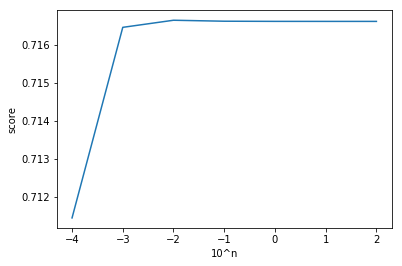

CPU times: user 7.88 s, sys: 2.02 s, total: 9.9 s
Wall time: 1min 17s


In [14]:
%%time
# Подберем параметр регуляризации С на исходном датасете
C1, score1 = tuning_model(X_train_scaled, y_train)

In [15]:
C1, score1

(0.01, 0.7166390000880288)

#### Approach #2

In [16]:
# Удалим категориальные признаки из данных
del X_train_lr['lobby_type']
for n in range(1, 6):
    del X_train_lr['r{}_hero'.format(n)]
    del X_train_lr['d{}_hero'.format(n)]

In [17]:
X_train_scaled2 = scaler.fit_transform(X_train_lr)

In [18]:
X_train_scaled2.shape

(97230, 92)

--- C =  0.0001
Time elapsed: 0:00:00.000065
[0.70947131 0.71054883 0.71177751 0.71169704 0.71359801]
--- C =  0.001
Time elapsed: 0:00:00.000018
[0.71452753 0.71590583 0.7163856  0.71691469 0.71860973]
--- C =  0.01
Time elapsed: 0:00:00.000019
[0.7147459  0.7163128  0.71633048 0.71724976 0.71864826]
--- C =  0.1
Time elapsed: 0:00:00.000037
[0.71473702 0.71630672 0.71626466 0.71727287 0.71859946]
--- C =  1.0
Time elapsed: 0:00:00.000014
[0.7147351  0.71630497 0.71625722 0.71727556 0.71859379]
--- C =  10.0
Time elapsed: 0:00:00.000015
[0.71473466 0.71630423 0.71625645 0.71727649 0.71859226]
--- C =  100.0
Time elapsed: 0:00:00.000023
[0.71473475 0.7163042  0.71625606 0.71727679 0.71859226]


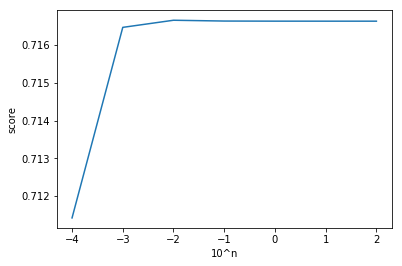

CPU times: user 6.98 s, sys: 1.23 s, total: 8.21 s
Wall time: 56.8 s


In [19]:
%%time
# Подберем параметр регуляризации С на датасете без категориальных признаков
C2, score2 = tuning_model(X_train_scaled2, y_train)

In [20]:
C2, score2

(0.01, 0.7166574405534297)

Как видно из графика, удаление категориальных признаков никак не повлияло на качество модели - значение коэффициента регуляризации и значение метрики ROC-AUC почти не изменились (разница получилась небольшой - в стотысячные доли). 

#### Approach #3

In [21]:
heroes = pd.read_csv('dictionaries/heroes.csv')
print ('Количество идентификаторов героев в игре:', len(heroes))


Количество идентификаторов героев в игре: 112


In [22]:
# Формируем "мешок слов" по героям

def bag_of_heroes(X,heroes):
    X_heroes = np.zeros((X.shape[0], len(heroes)))
    for i, match_id in enumerate(X.index):
        for p in range(5):
            X_heroes[i, X.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
            X_heroes[i, X.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1
    return X_heroes

In [23]:
X_heroes = bag_of_heroes(X_train_lr,heroes)

In [24]:
X_heroes.shape

(97230, 112)

In [25]:
X_joined = pd.concat([pd.DataFrame(X_train_scaled), pd.DataFrame(X_heroes)], axis=1)
X_joined.head()

,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,111
0,-1.732526,-2.544364,1.540688,-1.244228,1.400808,1.525972,0.734957,0.969743,-0.537757,-0.578083,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.732496,-2.540452,-0.927798,-0.292258,0.501314,-0.080139,-0.247570,-0.246859,-0.537757,1.017574,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.732466,-2.539231,1.540688,-0.568637,0.501314,0.151070,0.263085,1.190944,-0.537757,-0.578083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.732435,-2.532622,-0.575157,-0.691471,0.501314,0.962950,-0.198013,0.306142,-0.537757,-0.578083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.732405,-2.529221,1.540688,-1.182811,0.501314,0.348745,-0.124754,-0.357459,0.968527,-0.578083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
X_joined.shape # (97230, 103 + 112)

(97230, 215)

--- C =  0.0001
Time elapsed: 0:00:00.000084
[0.72380823 0.72420431 0.72470572 0.72601444 0.72689278]
--- C =  0.001
Time elapsed: 0:00:00.000100
[0.74488327 0.74677747 0.7440329  0.74888913 0.74737192]
--- C =  0.01
Time elapsed: 0:00:00.000097
[0.74964527 0.75280632 0.7491002  0.75549532 0.75169859]
--- C =  0.1
Time elapsed: 0:00:00.000075
[0.74958177 0.75316434 0.74936883 0.75610985 0.75154848]
--- C =  1.0
Time elapsed: 0:00:00.000096
[0.74951317 0.75317691 0.74937053 0.75614495 0.75148098]
--- C =  10.0
Time elapsed: 0:00:00.000134
[0.74950292 0.75317758 0.74936958 0.7561477  0.75147216]
--- C =  100.0
Time elapsed: 0:00:00.000082
[0.74950183 0.75317828 0.7493701  0.75614732 0.75147132]


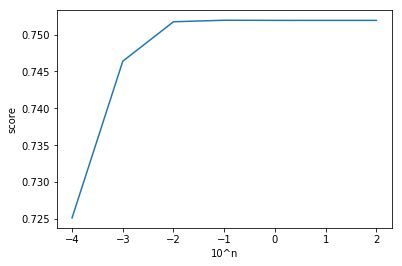

CPU times: user 15.7 s, sys: 4.51 s, total: 20.2 s
Wall time: 2min 47s


In [34]:
%%time
# Подберем параметр регуляризации С на датасете с доп. признаками  
C3, score3 = tuning_model(X_joined, y_train)

In [35]:
C3, score3

(0.1, 0.7519546556305338)

После составления "мешка слов" по героям качество модели улучшилось. Наилучшее качество достигается при  коэффициенте регуляризации C = 0.1 и равно 0.75194. 

In [27]:
lr = LogisticRegression(C=0.1, random_state=42)

In [28]:
%%time
lr.fit(X_joined, y_train)

CPU times: user 8.18 s, sys: 1.35 s, total: 9.53 s
Wall time: 10 s


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

**Что указать в отчете**:

В отчете по данному этапу вы должны ответить на следующие вопросы:

1.Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

2.Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем вы можете объяснить это изменение?

3.Сколько различных идентификаторов героев существует в данной игре?

4.Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?

5.Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?

**Ответы** :

1.Макс.качество град. бустинга равно 0.70616, макс.качество логистической регрессии выше и равно 0.71663. Видимо, это обусловлено тем, что град. бустинг учитывал категориальные признаки при построении модели, в то время как лог. регрессия изначально приняла их за шум в данных и эти признаки не учитывались при построении модели. Также лог. регрессия работает быстрее по сравнению с бустингом - обучение модели град.бустинга на train data заняло 1min 25s, обучение модели лог. регрессии заняло 8.12 s.

2.Удаление категориальных признаков никак не повлияло на качество модели - значение показателя регуляризации и значение метрики ROC-AUC почти не изменились (разница получилась небольшой - в миллионные доли). Видимо, изначально алгоритм принял их за шум в данных и эти признаки не учитывались при построении модели, поэтому их искусственное удаление впоследствии  никак не повлияло на результат.

3.112

4.После составления "мешка слов" по героям качество модели улучшилось. Наилучшее качество достигается при значении показателя регуляризации C = 0.1 и равно 0.75195. Искусственное добавление признаков - информации о героях игры помогло модели выполнить более корректное предсказание.

5.Минимальное и максимальное значение прогноза на тестовой выборке получилось(0.003431763011054745, 0.9965682369889453). Качество прогноза на kaggle на тестовой выборке у лучшего алгоритма получилось 0.75528.

### Make prediction

In [29]:
data_test = pd.read_csv('features_test.csv')
data_test.head()

,match_id,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
0,6,1430287923,0,93,4,1103,1089,8,0,1,...,0,12.0,247.0,-86.0,272.0,3,4,2,0,118.0
1,7,1430293357,1,20,2,556,570,1,0,0,...,2,-29.0,168.0,-54.0,NaN,3,2,2,1,16.0
2,10,1430301774,1,112,2,751,808,1,0,0,...,1,-22.0,46.0,-87.0,186.0,1,3,3,0,-34.0
3,13,1430323933,1,27,3,708,903,1,1,1,...,2,-49.0,30.0,-89.0,210.0,3,4,2,1,-26.0
4,16,1430331112,1,39,4,1259,661,4,0,0,...,0,36.0,180.0,-86.0,180.0,1,3,2,1,-33.0


In [30]:
data_test.shape

(17177, 103)

In [31]:
X_test = data_test

In [32]:
# Заменяем пропуски в данных на 0
X_test = X_test.fillna(0) 

In [33]:
# Формируем "мешок слов" по героям
X_heroes_test = bag_of_heroes(X_test, heroes)

In [34]:
X_heroes_test.shape

(17177, 112)

In [35]:
pd.DataFrame(X_heroes_test).head()

,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,111
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
4,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test))

In [37]:
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
0,-1.729109,-2.514875,-0.925258,1.264932,0.474746,-0.237743,-0.137094,-0.370005,-0.532732,1.003884,...,-0.992369,0.450016,1.908352,-0.400363,1.149479,0.017743,0.554260,-0.571552,-0.983356,3.200079
1,-1.729078,-2.513895,-0.572547,-0.966915,-1.365630,-1.207913,-1.255660,-1.145090,-0.532732,-0.593200,...,1.788142,-0.574649,0.836945,1.723080,-1.597294,0.017743,-1.177689,-0.571552,0.433564,0.600867
2,-1.728988,-2.512377,-0.572547,1.845824,-1.365630,-0.862057,-0.742715,-1.145090,-0.532732,-0.593200,...,0.397887,-0.399706,-0.817633,-0.466721,0.281014,-1.038655,-0.311714,0.668978,-0.983356,-0.673257
3,-1.728897,-2.508381,-0.572547,-0.752903,-0.445442,-0.938323,-0.537967,-1.145090,0.968865,1.003884,...,1.788142,-1.074486,-1.034626,-0.599436,0.523376,0.017743,0.554260,-0.571552,0.433564,-0.469397
4,-1.728807,-2.507087,-0.572547,-0.386024,0.474746,0.038942,-1.059534,-0.812911,-0.532732,-0.593200,...,-0.992369,1.049820,0.999690,-0.400363,0.220423,-1.038655,-0.311714,-0.571552,0.433564,-0.647774


In [38]:
X_test_scaled.shape

(17177, 103)

In [39]:
X_joined_test = pd.concat([pd.DataFrame(X_test_scaled), pd.DataFrame(X_heroes_test)], axis=1)

In [40]:
X_joined_test.shape

(17177, 215)

In [41]:
y_pred = lr.predict_proba(X_joined_test)

In [43]:
np.min(y_pred), np.max(y_pred)

(0.003431763011054745, 0.9965682369889453)

In [104]:
y_kaggle = pd.concat([X_test.match_id, pd.DataFrame(y_pred)],axis=1)
y_kaggle.drop([0], axis=1, inplace=True)
y_kaggle.columns = ['match_id','radiant_win']
y_kaggle.tail()

,match_id,radiant_win
17172,114369,0.734640
17173,114377,0.646233
17174,114378,0.242550
17175,114393,0.635741
17176,114398,0.439654


In [105]:
y_kaggle.to_csv('pred1_kaggle.csv',sep=',',encoding='utf-8', index = False)